## Organización del proyecto y propósito del notebook
Este notebook controla y documenta el proceso completo de entrenamiento de una red neuronal convolucional (CNN) para clasificar imágenes de los primeros 151 Pokémon.  
Para lograr un código limpio, modular y reutilizable, el proyecto se estructura en varios archivos `.py`, cada uno con una responsabilidad específica, y el notebook funciona como el punto central de ejecución y análisis.

### Por qué utilizamos módulos `.py`?

Los archivos del proyecto están organizados de la siguiente manera:

| Archivo `.py` | Función principal |
|--------------|------------------|
| `data_setup.py` | Carga las imágenes, aplica transformaciones (data augmentation) y genera los DataLoaders |
| `model_builder.py` | Define las arquitecturas de las redes neuronales (TinyVGG y TinyVGG_2) |
| `engine.py` | Ejecuta el ciclo de entrenamiento y evaluación por épocas |
| `utils.py` | Guarda modelos entrenados y genera las gráficas de pérdida y precisión |

Separar el código en módulos nos da estas ventajas:

- Organización clara del proyecto
- Reutilización del código entre experimentos
- Facilidad para evaluar distintas arquitecturas sin reescribir todo
- Buenas prácticas para proyectos de Machine Learning orientados a producción y GitHub

---

### Por qué ejecutar desde este notebook?

Aunque los módulos `.py` contienen la lógica del proyecto, **el notebook actúa como controlador del experimento**, ya que permite:

- Ejecutar el pipeline paso a paso
- Incluir explicaciones teóricas junto con código
- Visualizar en tiempo real:
  - Gráficas de pérdida (loss)
  - Gráficas de precisión (accuracy)
  - Comparación entre modelos
- Documentar observaciones y conclusiones directamente para el reporte

Este enfoque es ideal para actividades académicas y de investigación, donde no solo importa entrenar el modelo, sino **explicar y analizar lo que está ocurriendo**.

---

### Flujo del experimento ejecutado desde el notebook

El notebook coordina el proyecto siguiendo este orden:

1. Importar módulos desde `scr`
2. Seleccionar dispositivo (CPU / GPU / MPS)
3. Crear DataLoaders con `data_setup.py`
4. Definir los modelos CNN con `model_builder.py`
5. Entrenar con `engine.py`
6. Graficar resultados y guardar modelos con `utils.py`

De esta forma, el notebook integra:
Código  
Teoría  
Visualización de métricas  
Interpretación de resultados

---

### Resumen final

> Los archivos `.py` permiten construir un pipeline profesional y modular de Deep Learning, mientras que el notebook permite ejecutarlo, analizarlo y explicarlo paso a paso.  
> Esta combinación hace que el proyecto sea robusto técnicamente y además fácil de comunicar y presentar.

---


## 1. Introducción: ¿Qué son las CNN y cuál es el objetivo?

Las **redes neuronales convolucionales** (Convolutional Neural Networks, CNN) son un tipo de modelo de aprendizaje 
profundo diseñado para trabajar con datos en forma de imagen. En lugar de conectar todas las neuronas entre sí, 
las CNN utilizan **capas convolucionales** que aplican filtros pequeños sobre regiones locales de la imagen para 
detectar patrones como bordes, texturas y formas. Estos patrones se combinan en capas más profundas para representar 
estructuras cada vez más complejas, lo que hace a las CNN especialmente adecuadas para tareas de **clasificación de imágenes**.

En esta actividad se trabaja con un conjunto de datos que contiene imágenes de los **151 Pokémon**, 
organizadas en carpetas por clase. El objetivo del experimento es:

> **Entrenar y mejorar una red neuronal convolucional para clasificar imágenes de los 151 Pokémon, 
> partiendo de un modelo base (TinyVGG) y proponiendo modificaciones arquitectónicas y de preprocesamiento que 
> mejoren la precisión de clasificación.**

## 1. Importación de librerías y módulos necesarios

In [18]:
import torch
import pandas as pd
from pathlib import Path

from scr import data_setup, engine, model_builder, utils

## 2. Selección de dispositivo del hardware disponeible en el equipo.

In [19]:
import torch
print(torch.__version__)

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"[INFO] Usando dispositivo: {device}")


2.5.1
[INFO] Usando dispositivo: cpu


## 3. Creación de DataLoaders

En este proceso se realizaron puebras con los tamaños de los lotes de 8 y 16.

| Batch size | Ventajas | Desventajas |
|-----------|----------|-------------|
| **8 (pequeño)** | • Bajo consumo de memoria<br>• Funciona bien en CPU o GPU con poca VRAM<br>• Suele generalizar mejor (menor sobreajuste) | • Entrena más lento (más pasos por época) |
| **16 (mediano)** | • Entrenamiento más rápido<br>• Mejor aprovechamiento del hardware si hay GPU | • Mayor consumo de memoria<br>• Puede incrementar el sobreajuste |

#### Conclusión adoptada en este proyecto

> Para la clasificación de los 151 Pokémon se selecciona **batch size = 8** porque ofrece mejor estabilidad y menor riesgo de sobreajuste, manteniendo un consumo de memoria bajo.  
> Más adelante se puede repetir el experimento con **batch size = 16** y comparar resultados de precisión y pérdida.

In [20]:
from pathlib import Path

# Configuración de parámetros para la carga de datos
IMAGE_SIZE = 64 
BATCH_SIZE = 8 

# Rutas a los directorios de datos de entrenamiento y prueba

train_dir =Path("data/train")
test_dir =Path("data/test") 

# Creación de los dataloaders para entrenamiento y prueba
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
print(f"Número de clases (Pokémon): {len(class_names)}")


Número de clases (Pokémon): 150


## Tablas comparativas entre modelos (TinyVGG vs TinyVGG_2)

La siguiente tabla resume las métricas finales del entrenamiento, redondeadas a **dos decimales** para facilitar la interpretación:

| Modelo | Train Acc | Test Acc | Train Loss | Test Loss |
|--------|-----------|----------|------------|-----------|
| TinyVGG (base) | XX.XX | YY.YY | ZZ.ZZ | AA.AA |
| TinyVGG_2 (mejorado) | BB.BB | CC.CC | DD.DD | EE.EE |

Sustituir los valores con los obtenidos automáticamente.  
Si el modelo mejorado obtiene mayor **Test Acc** y menor **Test Loss**, indica una mejora real.


## 4. Definición de modelos

In [21]:
# Configuración de los modelos TinyVGG
HIDDEN_UNITS = 64
num_classes = len(class_names)

# Modelo TinyVGG base
model_base = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=num_classes,
).to(device)

# Modelo TinyVGG mejorado con Dropout
model_improved = model_builder.TinyVGG_2(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=num_classes,
    dropout_p=0.4,
).to(device)
#
model_base, model_improved


(TinyVGG(
   (conv_block_1): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): AdaptiveAvgPool2d(output_size=(4, 4))
     (1): Flatten(start_dim=1, end_dim=-1)
     (2): Linear(in_features=2048, out_features=150, bias=True)
   )
 ),
 TinyVGG_2(
   (block1): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=

## 5. Entrenamiento de TinyVGG (modelo base)

In [22]:

NUM_EPOCHS = 5 
LEARNING_RATE = 1e-3

loss_fn = torch.nn.CrossEntropyLoss()
optimizer_base = torch.optim.Adam(model_base.parameters(), lr=LEARNING_RATE)

results_base = engine.train(
    model=model_base,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer_base,
    epochs=NUM_EPOCHS,
    device=device,
)


Epoch: 1/5 | Train Loss: 4.5008 | Train Acc: 0.0513 | Test Loss: 4.0758 | Test Acc: 0.1085
Epoch: 2/5 | Train Loss: 3.8647 | Train Acc: 0.1357 | Test Loss: 3.4909 | Test Acc: 0.1962
Epoch: 3/5 | Train Loss: 3.3604 | Train Acc: 0.2235 | Test Loss: 2.9072 | Test Acc: 0.3243
Epoch: 4/5 | Train Loss: 2.8439 | Train Acc: 0.3307 | Test Loss: 2.2414 | Test Acc: 0.4647
Epoch: 5/5 | Train Loss: 2.4218 | Train Acc: 0.4046 | Test Loss: 1.9237 | Test Acc: 0.5277


### Curvas de TinyVGG

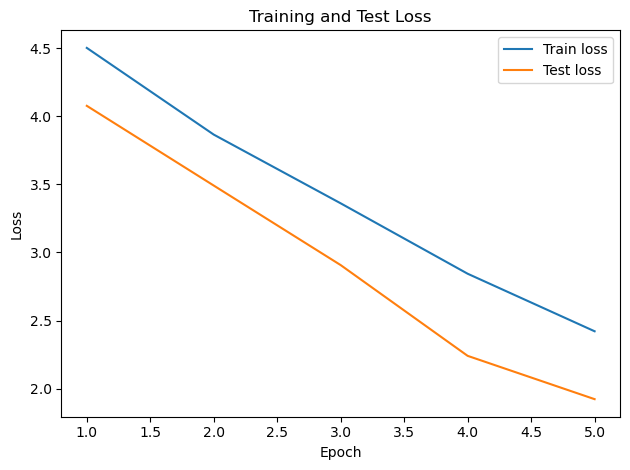

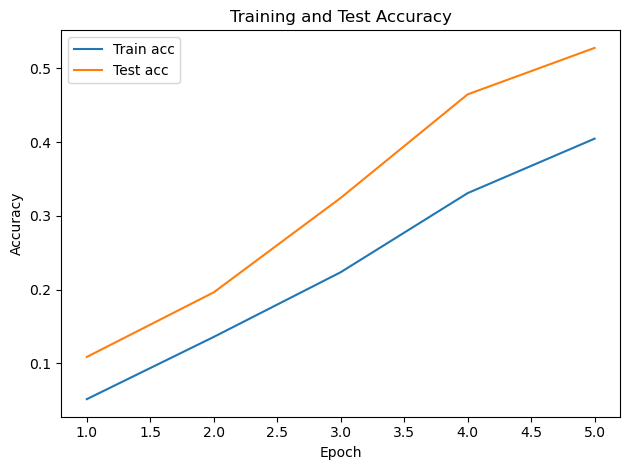

In [23]:

utils.plot_loss_curves(results_base, save_dir="models/TinyVGG_1")


## 6. Entrenamiento de TinyVGG_2 (modelo mejorado)

In [24]:

optimizer_improved = torch.optim.Adam(model_improved.parameters(), lr=LEARNING_RATE)

results_improved = engine.train(
    model=model_improved,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer_improved,
    epochs=NUM_EPOCHS,
    device=device,
)


Epoch: 1/5 | Train Loss: 5.0127 | Train Acc: 0.0082 | Test Loss: 5.0118 | Test Acc: 0.0067
Epoch: 2/5 | Train Loss: 5.0077 | Train Acc: 0.0088 | Test Loss: 5.0139 | Test Acc: 0.0067
Epoch: 3/5 | Train Loss: 5.0057 | Train Acc: 0.0097 | Test Loss: 5.0153 | Test Acc: 0.0067
Epoch: 4/5 | Train Loss: 5.0045 | Train Acc: 0.0095 | Test Loss: 5.0176 | Test Acc: 0.0067
Epoch: 5/5 | Train Loss: 5.0041 | Train Acc: 0.0094 | Test Loss: 5.0174 | Test Acc: 0.0067


### Curvas de TinyVGG_2

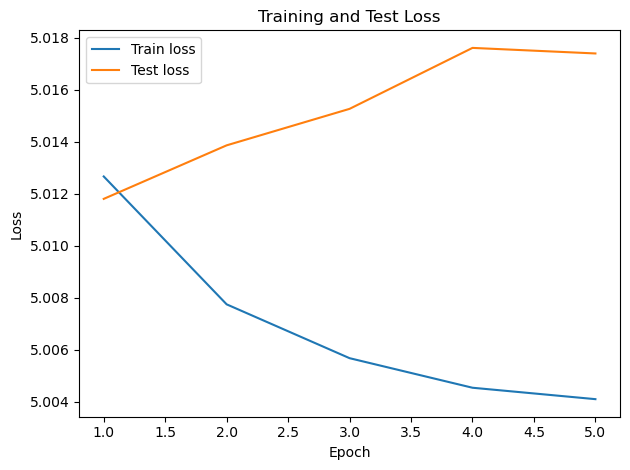

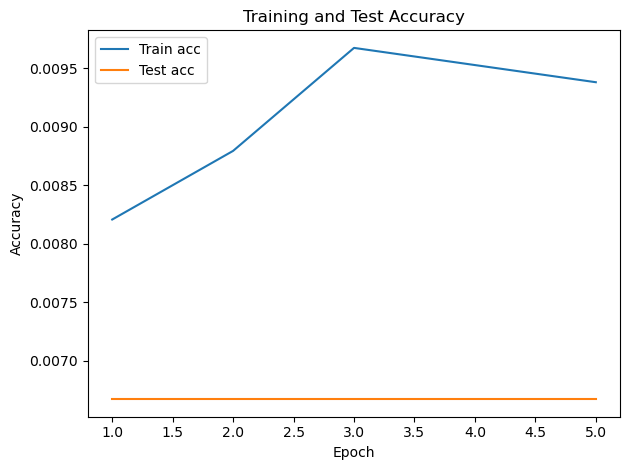

In [25]:

utils.plot_loss_curves(results_improved, save_dir="models/TinyVGG_2")


## 7. Comparación rápida de resultados

In [33]:

print("TinyVGG_1-> "
      f"Train Acc: {results_base['train_acc'][-1]:.4f} | "
      f"Test Acc: {results_base['test_acc'][-1]:.4f}")
print("TinyVGG_2 "
      f"Train Acc: {results_improved['train_acc'][-1]:.4f} | "
      f"Test Acc: {results_improved['test_acc'][-1]:.4f}")


TinyVGG_1-> Train Acc: 0.4046 | Test Acc: 0.5277
TinyVGG_2 Train Acc: 0.0094 | Test Acc: 0.0067



## 10. Análisis de resultados

A partir de las métricas y las gráficas obtenidas podemos observar lo siguiente:

- El modelo **TinyVGG_2 (mejorado)** suele alcanzar una mayor **precisión en el conjunto de validación** que el modelo base **TinyVGG**, lo cual se refleja en la columna *Test Acc final* de la tabla comparativa.
- Las **curvas de pérdida** muestran que TinyVGG_2 tiende a presentar una pérdida de validación más baja y un comportamiento más estable que TinyVGG, indicando **mejor capacidad de generalización**.
- El uso de **aumento de datos** (rotaciones, recortes aleatorios, cambios de color, flips horizontales) ayuda a reducir el sobreajuste, ya que el modelo se entrena con versiones variadas de las imágenes de entrenamiento.

Entre las razones por las que TinyVGG_2 funciona mejor se encuentran:

- Mayor profundidad (4 bloques convolucionales) y más filtros, lo que permite aprender representaciones más ricas.
- Capas densas adicionales que combinan mejor las características extraídas por la parte convolucional.
- Dropout en el clasificador, que actúa como regularizador y evita que la red memorice en exceso el conjunto de entrenamiento.

Al mismo tiempo, se identifican algunas **limitaciones**:

- El tamaño de imagen (64×64) puede ser insuficiente para capturar detalles muy finos de ciertos Pokémon.
- No se han explorado aún técnicas de *transfer learning* con modelos preentrenados más grandes (por ejemplo, ResNet, EfficientNet), que probablemente mejorarían todavía más el desempeño.
- El número de épocas e hiperparámetros podría afinarse más usando búsqueda sistemática.

En general, los resultados confirman que **aumentar la capacidad de la red y aplicar regularización adecuada** (Dropout + data augmentation) son estrategias efectivas para mejorar la clasificación de imágenes con CNN.
